In [1]:
import torch
import numpy as np
import csv
import pandas as pd

import json

from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv

import torch.nn.functional as F
from torch.optim import SGD
from torch.nn import ReLU

from tqdm import tqdm

from collections import defaultdict

In [2]:
device = 'cuda'

# Load Data

In [3]:
raw_np = np.load('datasets/facebook.npz')

In [4]:
edges = torch.tensor(raw_np['edges'].T).to(device)
node_features = torch.tensor(raw_np['features']).to(device)
target = torch.tensor(raw_np['target']).to(device)

In [5]:
all_indices = np.arange(node_features.shape[0])
train_indices = np.random.choice(all_indices, int(node_features.shape[0]*0.8), replace=False)
test_indices = all_indices[~np.isin(all_indices, train_indices)]

In [6]:
train_mask = np.isin(all_indices, train_indices)
train_mask = torch.tensor(train_mask)

test_mask = ~np.isin(all_indices, train_indices)
test_mask = torch.tensor(test_mask)

In [7]:
graph = Data(
    x=node_features, 
    edge_index=edges, 
    y=target,
    train_mask = train_mask, 
    test_mask = test_mask
).contiguous().to(device)

In [8]:
graph_nl = NeighborLoader(
    data=graph, 
    num_neighbors=[-1],
    batch_size=32
)

# Build Model

In [9]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(128, 16)
        self.conv2 = GCNConv(16, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

# Train Model

In [19]:
gcn_model = GCN().to(device)

optimizer = SGD(gcn_model.parameters(), lr=0.5)
CELoss = torch.nn.CrossEntropyLoss()

results = defaultdict(list)
epochs = tqdm(range(100))
for epoch in epochs:
    gcn_model.train()
    optimizer.zero_grad()
    loss = 0
    for batch in graph_nl:
        pred = gcn_model(batch)
        loss += CELoss(pred[batch.train_mask], batch.y[batch.train_mask])
    loss /= len(graph_nl)
    loss.backward()
    optimizer.step()

    results['train_loss'].append(loss.to('cpu'))

    gcn_model.eval()
    pred = gcn_model(graph)
    results['test_loss'].append(CELoss(pred[graph.test_mask], graph.y[graph.test_mask]).to('cpu'))

    results['test accuracy'].append((pred[graph.test_mask].argmax(axis=1)==graph.y[graph.test_mask]).sum()/len(graph.y[graph.test_mask]))
    results['full accuracy'].append((pred.argmax(axis=1)==graph.y).sum()/len(graph.y))
    
    epochs.set_description(f"{epoch}/{len(epochs)}, Loss {loss:.4f}")

99/100, Loss 0.6053: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


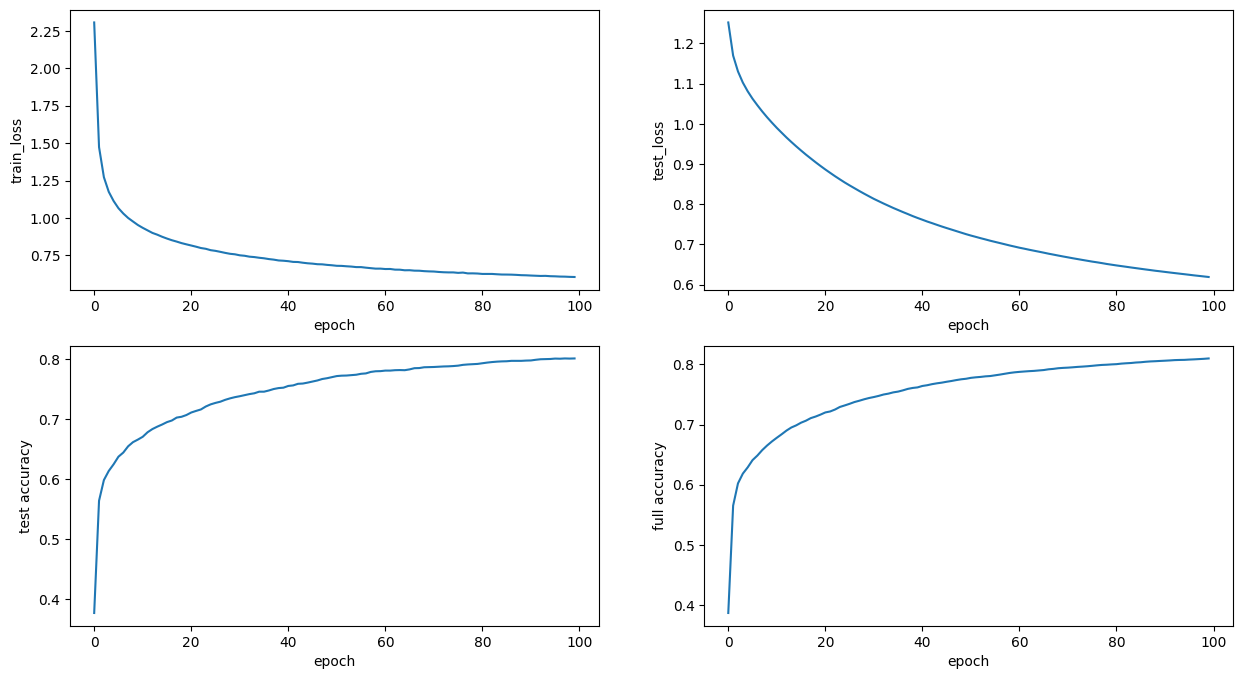

In [37]:
import matplotlib.pyplot as plt

epochs = np.arange(len(epochs))
n_plots = len(results)
nrows = int(np.ceil(n_plots/2))

fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(15, 8))

count = 0
for result in results:
    col = count%2
    row = count//2
    ax[row, col].plot([i.to('cpu').detach().numpy() for i in results[result]])
    ax[row, col].set_xlabel("epoch")
    ax[row, col].set_ylabel(result)
    count += 1
